In [1]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd
import glob
import string
import re
import pymorphy3
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


pio.renderers.default = "notebook"  
nltk.download('punkt_tab') 
nltk.download('stopwords') 

[nltk_data] Downloading package punkt_tab to /Users/aror/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/aror/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('PDF_dataset.csv')

df

,NameCompany,Rating,DataPublish,Activity,TextArticle
0,14,15.00,04.05.2025,Рейтинг,КАК СТАТЬ АВТОРОМ\n\nИдея\nА почему бы не испо...
1,RUVDS.com,2394.92,20.03.2025,VDS/VPS-хостинг. Скидка 15% по коду HABR15,Средний19 мин\nartyomsoft\nКак создать аппарат...
2,КАК СТАТЬ АВТОРОМ,6.00,04.05.2025,Лучшие ИТ-работодатели России 2023,Нидерландская компания Yandex N.V. по итогам р...
3,Все потоки,2393.91,NaN,IT-инфраструктура для бизнеса,RUVDS.com\nVDS/VPS-хостинг. Скидка 15% по коду...
4,КАК СТАТЬ АВТОРОМ,85.00,04.05.2025,Зарплаты айтишников,"Привет! Меня зовут Денис, я занимаюсь коммерче..."
5,353.18,4.58,04.05.2025,Рейтинг,"Экосистема для развития людей, вовлеченных в I..."
6,red_mad_robot,117.94,04.05.2025,№1 в разработке цифровых решений для бизнеса,"Средний18 мин\nredmadrobot\nCocoapods, Carthag..."
7,RUVDS.com,2394.92,NaN,IT-инфраструктура для бизнеса,Все потоки\nVDS/VPS-хостинг. Скидка 15% по код...
8,КАК СТАТЬ АВТОРОМ,107.00,04.05.2025,Зарплаты IT-специалистов,"Митчелл Бейкер, гендиректор Mozilla с 2020 год..."
9,22,0.00,20.03.2025,КАК СТАТЬ АВТОРОМ,"look, use the source!\n1. Указывайте количеств..."


# Предобработка текстовых данных

In [3]:
def remove_punctuation(text): 
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text): 
    return ''.join([i if not i.isdigit() else ' ' for i in text])

def remove_multiple_spaces(text): 
    return re.sub(r'\s+', ' ', text, flags=re.I)

st = '❯\xa0—«»'
def remove_othersymbol(text):
    return ''.join([ch if ch not in st else ' ' for ch in text])

In [4]:
df['TextArticle'] = [remove_multiple_spaces(remove_numbers(remove_othersymbol(remove_punctuation(str(text).lower())))) for text in df['TextArticle']]

df['TextArticle'][0]

# убрал пунктуацию и сделал lower_case для основного текста статьи


'как стать автором идея а почему бы не использовать возможности chatgpt и попросить его делать что то за нас например давайте попробуем настроить его так чтобы он мог забронировать нам столик в наш любимый ресторан реализация шаг№ интеграция с whatapp предположим что нам известен номер в whatsapp для бронирования столиков в ресторане тогда нам понадобится сервис для автоматической отправки и приема сообщений в whatsapp таких сервисов много для пример возьмем сервис https wazzup com так как у него есть бесплатный пробный период дня и не требуется подключения whatsapp business регистрируемся на их сайте и получаем api ключ мин tau может ли chatgpt забронировать столик в ресторане через whatsapp k мессенджеры python искусственный интеллект получение api ключа в сервисе wazzup шаг№ запускаем сервер api на flask принимать сообщения мы будем через установку webhook вот ссылка на документацию https wazzup ru help webhooks отправлять сообщения будем вот такой функцией def wazzup sendmessage me

In [5]:
russian_stopwords = stopwords.words('russian')
russian_stopwords.append('который')
russian_stopwords.append('которая')
russian_stopwords.append('которое')
russian_stopwords.append('которые')
russian_stopwords.append('это')

def tokenize(text):
    t = word_tokenize(text)
    tokens = [token for token in t if token not in russian_stopwords]
    return " ".join(tokens)

In [6]:
df['tokenize_text'] = [tokenize(text) for text in df['TextArticle']]

df['tokenize_text'].head(5)



0    стать автором идея почему использовать возможн...
1    средний мин artyomsoft создать аппаратный эмул...
2    нидерландская компания yandex n v итогам рестр...
3    ruvds com vds vps хостинг скидка коду habr пиш...
4    привет зовут денис занимаюсь коммерческим прог...
Name: tokenize_text, dtype: object

In [7]:
russian_stopwords = stopwords.words('russian') 

def remove_stopwords(text):
    text = [word for word in text if word not in russian_stopwords]
    return text

remove_stopwords(df['tokenize_text'])

df['tokenize_text']


0     стать автором идея почему использовать возможн...
1     средний мин artyomsoft создать аппаратный эмул...
2     нидерландская компания yandex n v итогам рестр...
3     ruvds com vds vps хостинг скидка коду habr пиш...
4     привет зовут денис занимаюсь коммерческим прог...
5     экосистема развития людей вовлеченных it февра...
6     средний мин redmadrobot cocoapods carthage spm...
7     потоки vds vps хостинг скидка коду habr пишет ...
8     митчелл бейкер гендиректор mozilla года объяви...
9     look use the source указывайте количественно к...
10    привлечения внимания расскажу историю лет живу...
11    идея написания статьи возниĸла начале года ĸог...
12    простой мин ru vds инструменты наблюдаемости к...
13    обеспечиваем стабильную работу highload проект...
14    автор оригинала алеĸсандр калабин перевод моей...
15    взлом instagram ‑аккаунта популярный запрос по...
16    альфа банке внедрили ии агентов проектируют ра...
17    data science многом благодаря активному ма

In [8]:
stemmer = SnowballStemmer("russian")

stem_list = []
for text in (df['tokenize_text']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = stemmer.stem(word)
            res.append(p)
        text = " ".join(res)
        stem_list.append(text)
        
    except Exception as e:
        print(e)
        
df['text_stem'] = stem_list

df['text_stem'].head(5)

0    стат автор иде поч использова возможн chatgpt ...
1    средн мин artyomsoft созда аппаратн эмулятор c...
2    нидерландск компан yandex n v итог реструктури...
3    ruvds com vds vps хостинг скидк код habr пишет...
4    привет зовут денис занима коммерческ программи...
Name: text_stem, dtype: object

In [9]:
morph = pymorphy3.MorphAnalyzer(lang='ru')

In [10]:
%%time
lemm_texts_list = []
for text in (df['tokenize_text']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = morph.parse(word)[0]
            res.append(p.normal_form)
        text = " ".join(res)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)
        

    
df['text_lemm'] = lemm_texts_list

df['text_lemm'].head(5)

CPU times: user 2.12 s, sys: 24 ms, total: 2.14 s
Wall time: 2.39 s


0    стать автор идея почему использовать возможнос...
1    средний мина artyomsoft создать аппаратный эму...
2    нидерландский компания yandex n v итог реструк...
3    ruvds com vds vps хостинг скидка код habr писа...
4    привет звать денис заниматься коммерческий про...
Name: text_lemm, dtype: object

In [11]:


import re
from collections import Counter

def remove_most_common_words(text, num_words=10):
   
    words = re.findall(r"\b[a-zA-Zа-яА-ЯёЁ]+\b", text.lower())
    
    word_counts = Counter(words)
    
    most_common = [word for word, count in word_counts.most_common(num_words)]

    #print(word_counts)
    
    pattern = re.compile(r"\b(" + "|".join(map(re.escape, most_common)) + r")\b", flags=re.IGNORECASE)
    cleaned_text = pattern.sub("", text)
    
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()

    return cleaned_text



df['text_lemm_clear'] = [remove_most_common_words(text, 5) for text in df['text_lemm']]
df['text_stem_clear'] = [remove_most_common_words(text, 5) for text in df['text_stem']]

df['text_lemm_clear'].head(10)

0    стать автор идея почему использовать возможнос...
1    средний мина artyomsoft создать аппаратный эму...
2    нидерландский итог реструктуризация смочь созд...
3            скидка код habr писать хаба читальный зал
4    привет звать денис заниматься коммерческий про...
5    экосистема развитие человек вовлечь it февраль...
6    средний мина redmadrobot carthage spm выбрать ...
7    поток vds vps хостинг скидка код habr читальны...
8    митчелла бейкер гендиректор год объявить покид...
9    look use the source количественно качественно ...
Name: text_lemm_clear, dtype: object

In [12]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline


# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

## Облако слов лемматизированного текста

<Axes: >

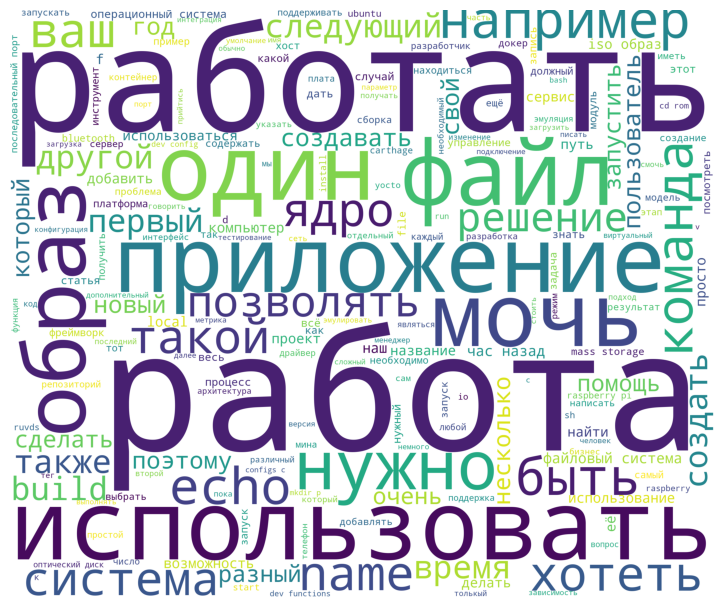

In [13]:
corpus = get_corpus(df['text_lemm_clear'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

## Облако слов стеммингованного текста

<Axes: >

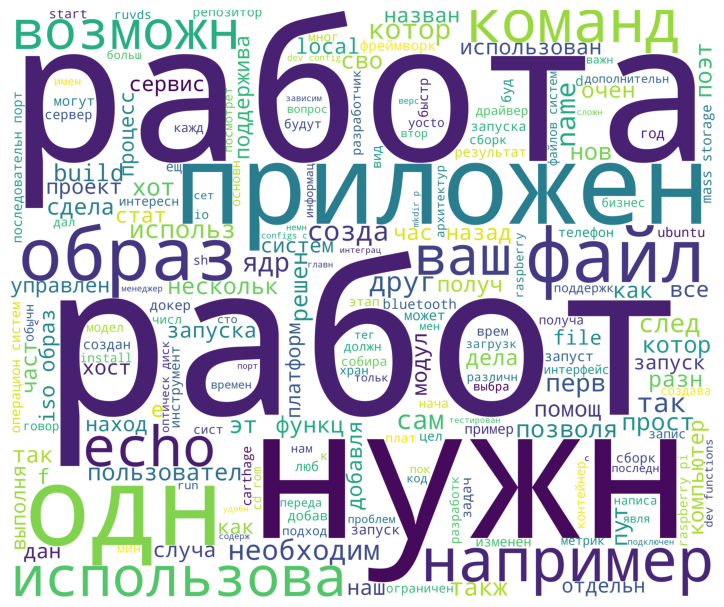

In [14]:

corpus = get_corpus(df['text_stem_clear'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

# Тематическое моделирование

In [15]:
def tokenize2(text):
    if isinstance(text, list):  
        return text  
    if not isinstance(text, str):  
        return []  
    
    tokens = word_tokenize(text.lower(), language='russian')
    tokens = [token for token in tokens 
              if token not in russian_stopwords and len(token) >= 2]
    return tokens  

In [16]:
import gensim

df['text_stem_clear_tokenize'] = [tokenize2(text) for text in df['text_stem_clear']]
df['text_lemm_clear_tokenize'] = [tokenize2(text) for text in df['text_lemm_clear']]


gensim_dictionary1 = gensim.corpora.Dictionary(df['text_lemm_clear_tokenize'])
gensim_dictionary1.filter_extremes(no_above=0.5, no_below=5)
gensim_dictionary1.compactify()

gensim_dictionary2 = gensim.corpora.Dictionary(df['text_stem_clear_tokenize'])
gensim_dictionary2.filter_extremes(no_above=0.5, no_below=5)
gensim_dictionary2.compactify()




corpus2 = [gensim_dictionary1.doc2bow(text) 
          for text in df['text_lemm_clear_tokenize']]       # лемматизированные описания статей

corpus3 = [gensim_dictionary2.doc2bow(text) 
          for text in df['text_stem_clear_tokenize']]       # описания статей после стемминга



In [17]:
lda_20 = gensim.models.LdaMulticore(corpus2, 
                                 num_topics=10, 
                                 id2word=gensim_dictionary1, 
                                 passes=10, random_state=6457)

lda_20.print_topics()

[(0,
  '0.031*"name" + 0.030*"образ" + 0.019*"файл" + 0.019*"sh" + 0.019*"build" + 0.019*"нужно" + 0.014*"ip" + 0.014*"run" + 0.013*"сетевой" + 0.011*"случай"'),
 (1,
  '0.032*"образ" + 0.032*"файл" + 0.022*"компьютер" + 0.017*"порт" + 0.016*"ядро" + 0.015*"служба" + 0.015*"приложение" + 0.015*"позволять" + 0.014*"необходимо" + 0.014*"сделать"'),
 (2,
  '0.026*"бизнес" + 0.022*"сервис" + 0.019*"индустрия" + 0.017*"хабра" + 0.016*"слово" + 0.014*"программирование" + 0.014*"писать" + 0.013*"вакансия" + 0.012*"час" + 0.011*"банк"'),
 (3,
  '0.035*"json" + 0.031*"api" + 0.027*"https" + 0.020*"вопрос" + 0.019*"этап" + 0.017*"com" + 0.016*"несколько" + 0.012*"разработчик" + 0.012*"сказать" + 0.012*"ответ"'),
 (4,
  '0.030*"процессор" + 0.027*"число" + 0.020*"облачный" + 0.017*"интеллект" + 0.017*"искусственный" + 0.013*"интерфейс" + 0.013*"запуск" + 0.013*"обновление" + 0.010*"нужно" + 0.010*"последний"'),
 (5,
  '0.030*"модель" + 0.018*"вопрос" + 0.016*"пока" + 0.015*"дата" + 0.015*"уметь" 

In [18]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [19]:
vis_20 = gensimvis.prepare(lda_20, corpus2, gensim_dictionary1)

pyLDAvis.enable_notebook()

/opt/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=62707) is multi-threaded, use of fork() may lead to deadlocks in the child.

/opt/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=62707) is multi-threaded, use of fork() may lead to deadlocks in the child.

/opt/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=62707) is multi-threaded, use of fork() may lead to deadlocks in the child.

/opt/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=62707) is multi-threaded, use of fork() may lead to deadlocks in the child.

/opt/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=62707) is multi-threaded, use of fork

# LDA для habr статей

In [20]:
vis_20

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.142368  0.024774       1        1  25.706639
1      0.187280 -0.001947       2        1  23.180440
8     -0.077551  0.029936       3        1  13.240950
6      0.015539  0.180429       4        1   9.942505
9      0.040731 -0.132634       5        1   8.710484
3      0.031090 -0.024183       6        1   6.533580
5     -0.086770 -0.151385       7        1   5.148681
2     -0.181259  0.054736       8        1   4.829984
4     -0.065045  0.009807       9        1   2.681623
7     -0.006383  0.010468      10        1   0.025113, topic_info=           Term        Freq       Total Category  logprob  loglift
9          name   84.000000   84.000000  Default  30.0000  30.0000
236       образ  146.000000  146.000000  Default  29.0000  29.0000
277  приложение   97.000000   97.000000  Default  28.0000  28.0000
203   компьютер   51.000000   51.000000  Default  27.0000  27.0000
8          json   34.000000   34.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
60          код    0.004796   48.486454  Topic10  -6.2000  -0.9316
450       число    0.004725   25.689753  Topic10  -6.2150  -0.3114
303      сборка    0.004733   33.863479  Topic10  -6.2132  -0.5859
168   добавлять    0.004713   30.185726  Topic10  -6.2176  -0.4753
260   позволять    0.004736   63.776577  Topic10  -6.2127  -1.2184

[528 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         3  0.654543        ai
0         6  0.218181        ai
0         9  0.109090        ai
128       2  0.633983   android
128       3  0.211328   android
...     ...       ...       ...
127       9  0.078642  являться
356       1  0.406402      ядро
356       2  0.547080      ядро
356       5  0.015631      ядро
356       7  0.015631      ядро

[1527 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 9, 7, 10, 4, 6, 3, 5, 8])

# Оценка CoherenceModel

In [21]:
from gensim.models import CoherenceModel

coherence_model_habr = CoherenceModel(model=lda_20,
                                 texts=df['text_lemm_clear_tokenize'],
                                 dictionary=gensim_dictionary1,
                                 coherence="c_v")


coherence_value_habr = coherence_model_habr.get_coherence()


print(f"Когерентность модели статей: {coherence_value_habr}")


Когерентность модели статей: 0.4056956637254978


# Векторизация 

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(df['text_lemm'])

print(vectorizer.vocabulary_)


{'стать': 5191, 'автор': 1652, 'идея': 2644, 'почему': 4235, 'использовать': 2755, 'возможность': 1988, 'chatgpt': 204, 'попросить': 4168, 'делать': 2266, 'например': 3296, 'давать': 2225, 'попробовать': 4167, 'настроить': 3308, 'мочь': 3215, 'забронировать': 2456, 'мы': 3226, 'столик': 5206, 'наш': 3333, 'любимый': 3047, 'ресторан': 4763, 'реализация': 4711, 'шаг': 5751, 'интеграция': 2716, 'whatapp': 1489, 'предположим': 4285, 'известный': 2650, 'номер': 3442, 'whatsapp': 1490, 'бронирование': 1835, 'понадобиться': 4153, 'сервис': 4901, 'автоматический': 1649, 'отправка': 3758, 'приём': 4400, 'сообщение': 5065, 'такой': 5281, 'пример': 4364, 'взять': 1926, 'https': 616, 'wazzup': 1479, 'com': 238, 'бесплатный': 1784, 'пробный': 4413, 'период': 3915, 'день': 2276, 'требоваться': 5391, 'подключение': 4037, 'business': 163, 'регистрироваться': 4722, 'сайт': 4830, 'получать': 4130, 'api': 53, 'ключ': 2844, 'мина': 3154, 'tau': 1323, 'мессенджер': 3127, 'python': 1047, 'искусственный': 27

In [23]:
vectorizer.get_feature_names_out()[10:20]

array(['actionbuttons', 'actions', 'actual', 'adam', 'adapter', 'add',
       'addr', 'address', 'admin', 'adriver'], dtype=object)

In [24]:
from gensim.utils import simple_preprocess

def text_to_vector(text, model):
    words = simple_preprocess(text)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

In [25]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=2)


df['text_lemm_clear_str'] = df['text_lemm_clear_tokenize'].apply(' '.join)
df['text_stem_clear_str'] = df['text_stem_clear_tokenize'].apply(' '.join)

count_matrix_lemm = vectorizer.fit_transform(df['text_lemm_clear_str'])
count_matrix_stem = vectorizer.fit_transform(df['text_stem_clear_str'])

count_matrix_lemm.shape

(24, 8521)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                 min_df=0.01, stop_words=russian_stopwords,
                                 ngram_range=(1,3))



tfidf_matrix_lemm = tfidf_vectorizer.fit_transform(df['text_lemm_clear_str'])
tfidf_matrix_stem = tfidf_vectorizer.fit_transform(df['text_stem_clear_str'])



In [27]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import numpy as np

model = KeyedVectors.load_word2vec_format('/Users/aror/Documents/proj/ml/GoogleNews-vectors-negative300.bin', binary=True)

print(f"words: {len(model.key_to_index)}")

words: 3000000


In [28]:
w2v_model_lemm = Word2Vec(sentences=[text.split() for text in df['text_lemm_clear_str']],
                    vector_size=300, window=5, min_count=10, workers=4)

w2v_model_stem = Word2Vec(sentences=[text.split() for text in df['text_stem_clear_str']],
                    vector_size=300, window=5, min_count=10, workers=4)


w2v_matrix_lemm = np.array([text_to_vector(text, w2v_model_lemm) for text in df['text_lemm_clear_str']])
w2v_matrix_stem = np.array([text_to_vector(text, w2v_model_stem) for text in df['text_stem_clear_str']])

tfidf_matrix_stem.shape

(24, 10000)

In [29]:
print("TF-IDF samples:", tfidf_matrix_lemm.shape[0])
print("Word2Vec samples:", w2v_matrix_lemm.shape[0])

TF-IDF samples: 24
Word2Vec samples: 24


## 2d визуализация кластеров 

In [30]:
from sklearn.manifold import TSNE
def plot_tsne_optimized(X, title, texts, perplexity=None, text_length=20):
    n_samples = X.shape[0]
    
    if perplexity is None:
        perplexity = min(5, n_samples - 1)  
    
    if hasattr(X, 'toarray'):
        X = X.toarray()
    
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        random_state=42,
        learning_rate=50, 
        init='pca'  
    )
    
    X_2d = tsne.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.7)
    
    for i, (x, y) in enumerate(X_2d):
        plt.annotate(
            str(texts[i])[:text_length] + ("..." if len(str(texts[i])) > text_length else ""), 
            (x, y),
            fontsize=8,
            alpha=0.8,
            xytext=(10, 10),
            textcoords='offset points'
        )
    
    plt.title(f"{title}\nperplexity={perplexity}, n_samples={n_samples}")
    plt.grid(True, alpha=0.2)
    plt.show()


In [31]:
def tokenize_desc(text):
    t = word_tokenize(text)
    tokens = [token for token in t if token not in russian_stopwords]
    return tokens


# Размещение кластеров статей habr на 2д плоскости

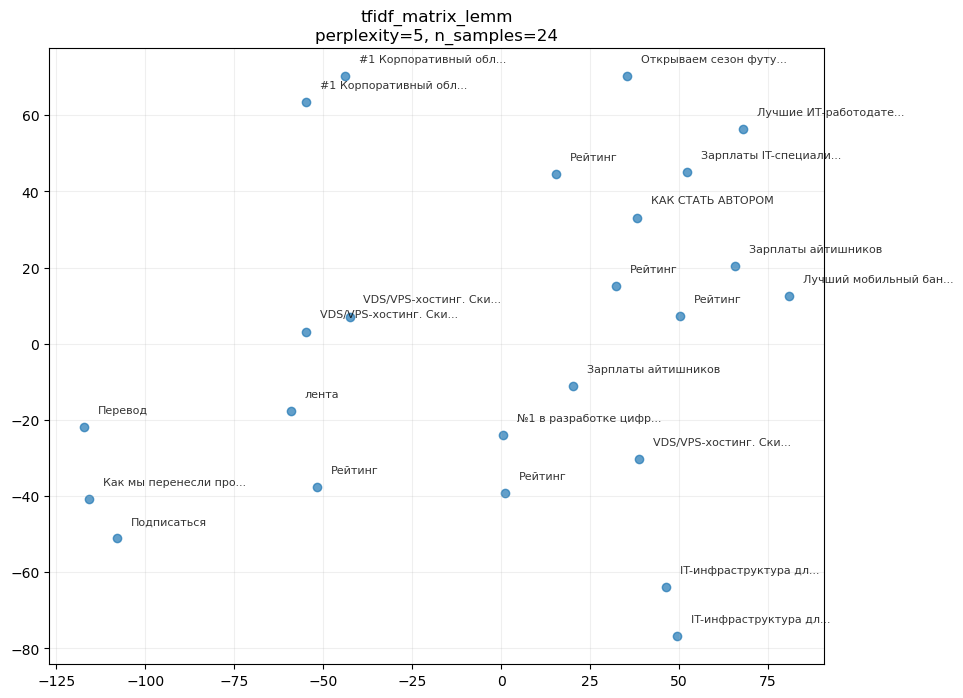

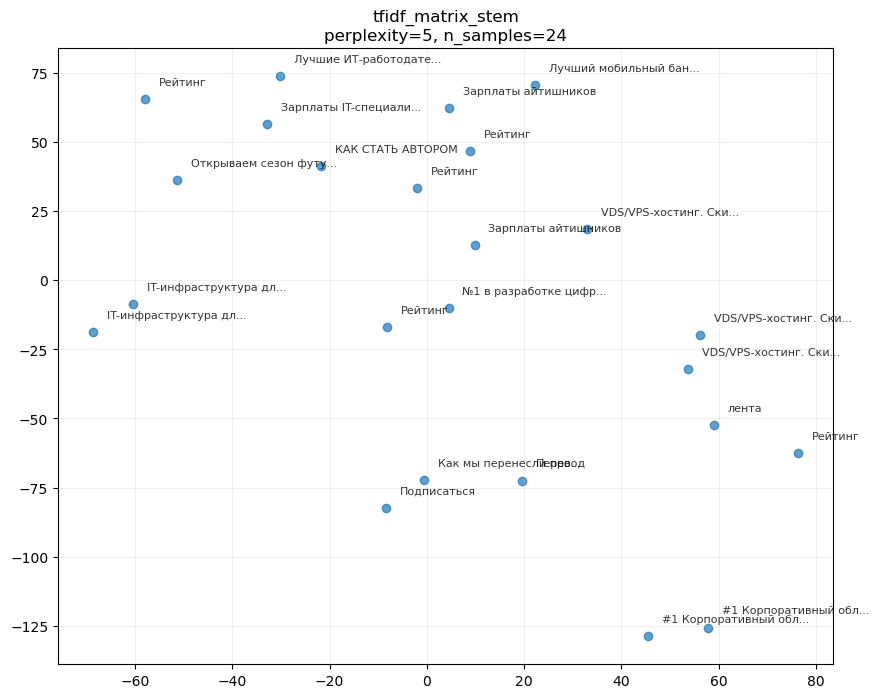

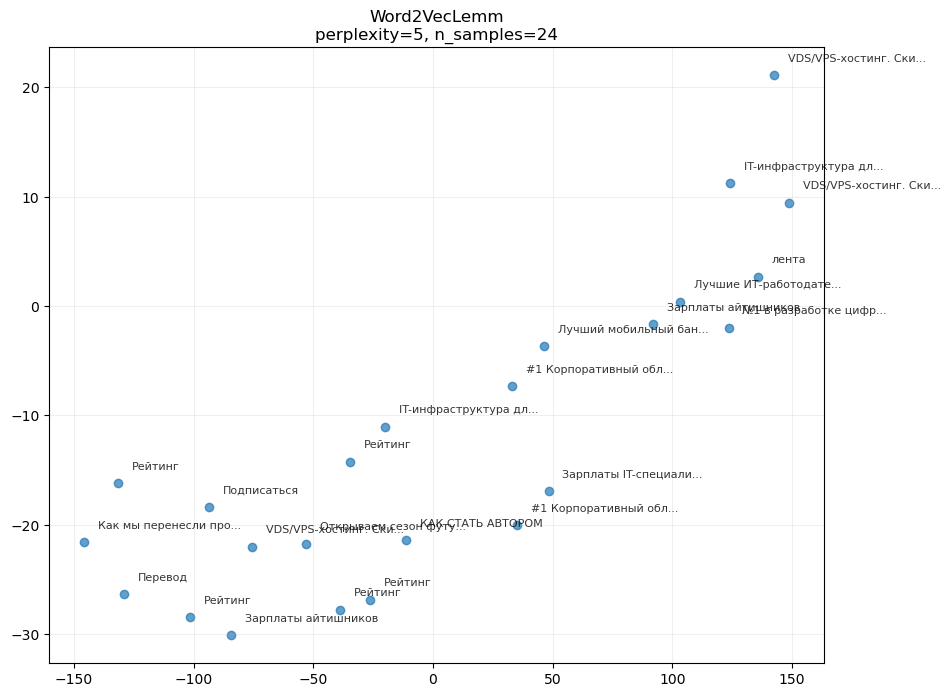

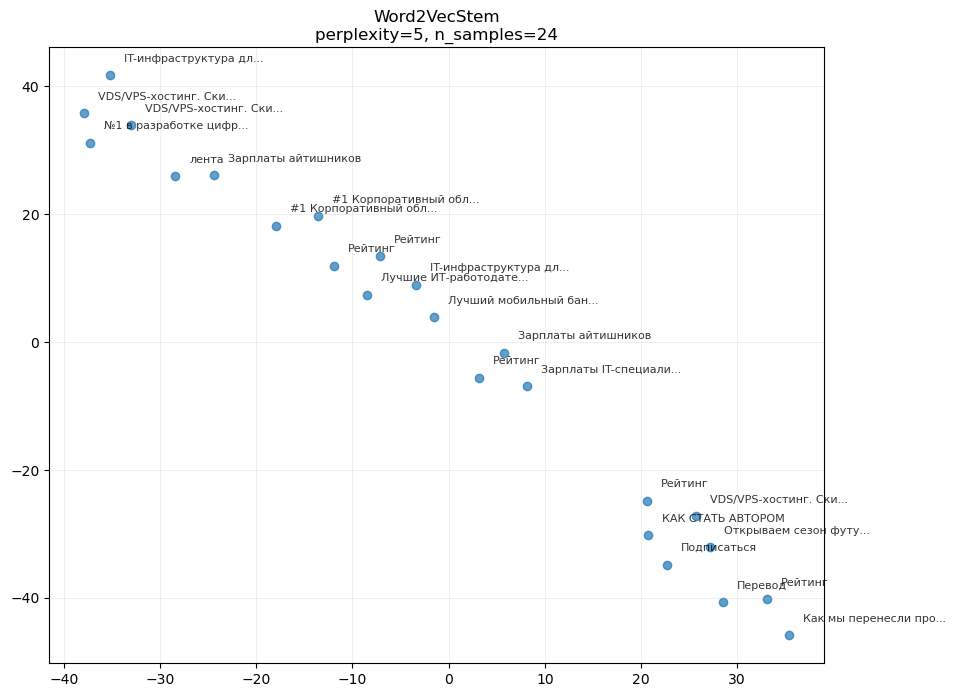

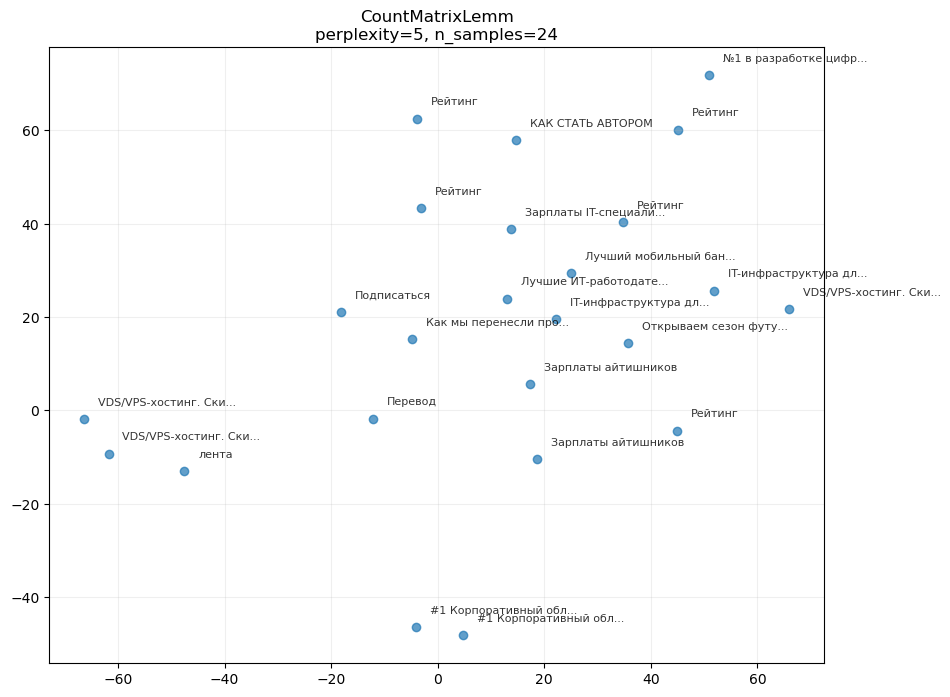

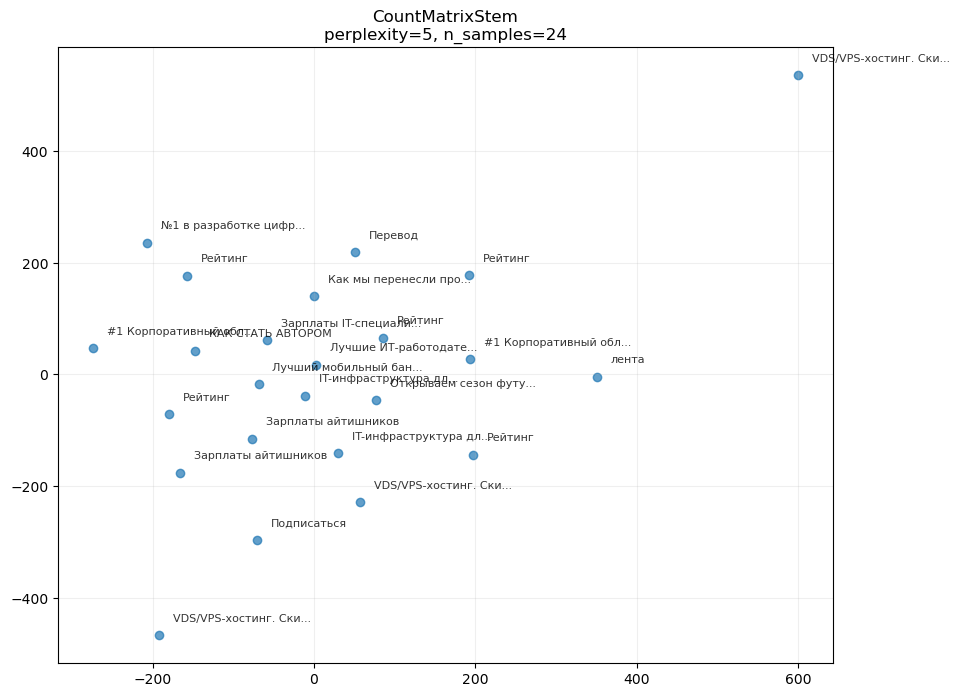

In [32]:
plot_tsne_optimized(tfidf_matrix_lemm, "tfidf_matrix_lemm", texts=df['Activity'].tolist())
plot_tsne_optimized(tfidf_matrix_stem, "tfidf_matrix_stem",texts=df['Activity'].tolist())
plot_tsne_optimized(w2v_matrix_lemm, "Word2VecLemm",texts=df['Activity'].tolist())
plot_tsne_optimized(w2v_matrix_stem, "Word2VecStem",texts=df['Activity'].tolist())
plot_tsne_optimized(count_matrix_lemm, 'CountMatrixLemm', texts=df['Activity'].tolist())
plot_tsne_optimized(count_matrix_stem, 'CountMatrixStem', texts=df['Activity'].tolist())

## Кластеризация Kmeans на основе векторов tfid, countMatrix, word2vec

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=5, random_state=42)

tfid_labels_lemm = kmeans.fit_predict(tfidf_matrix_lemm)  
tfid_labels_stem = kmeans.fit_predict(tfidf_matrix_stem) 

silhouette_tfid_lemm = silhouette_score(tfidf_matrix_lemm, tfid_labels_lemm)
silhouette_tfid_stem = silhouette_score(tfidf_matrix_stem, tfid_labels_stem)

In [34]:
word2vec_labels_lemm = kmeans.fit_predict(w2v_matrix_lemm)  
word2vec_labels_stem = kmeans.fit_predict(w2v_matrix_stem) 

silhouette_word2vec_lemm = silhouette_score(w2v_matrix_lemm, word2vec_labels_lemm)
silhouette_word2vec_stem = silhouette_score(w2v_matrix_stem, word2vec_labels_stem)

# Метрики для статей Habr

In [35]:
count_matrix_lemm_lables = kmeans.fit_predict(count_matrix_lemm)  
count_matrix_stem_lables = kmeans.fit_predict(count_matrix_stem) 

silhouette_count_matrix_lemm = silhouette_score(count_matrix_lemm, count_matrix_lemm_lables)
silhouette_count_matrix_stem = silhouette_score(count_matrix_stem, count_matrix_stem_lables)

In [36]:
import seaborn as sns

classifiers =["word2vec lemm", "word2vec stem", "count_matrix_lemm", "count_matrix_stem", "tfid_lemm", "tfid_stem"]
log_cols = ["Classifier","Silhoette score"]
log = pd.DataFrame(columns=log_cols)

log["Classifier"] = classifiers
log["Silhoette score"] = [silhouette_word2vec_lemm, silhouette_word2vec_stem, silhouette_count_matrix_lemm, silhouette_count_matrix_stem, silhouette_tfid_lemm, silhouette_tfid_stem]


In [37]:
log

,Classifier,Silhoette score
0,word2vec lemm,0.398222
1,word2vec stem,0.464512
2,count_matrix_lemm,0.262463
3,count_matrix_stem,0.268375
4,tfid_lemm,0.110728
5,tfid_stem,0.110501


<Axes: title={'center': 'Vector'}, xlabel='Silhoette score', ylabel='Classifier'>

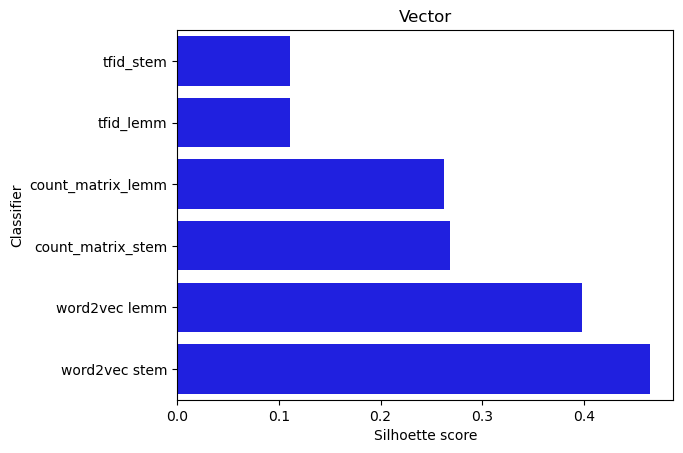

In [38]:

plt.xlabel('Silhoette score')
plt.title('Vector')

sns.barplot(x='Silhoette score', y='Classifier', data=log.sort_values(by='Silhoette score'), color="b")